In [2]:
elastic_rods_dir = '../../../add_params_elastic_rods/python'
weaving_dir = '../'
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
import copy

In [3]:
# Reloadable libraries
import analysis_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, importlib
importlib.reload(analysis_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (initialize_linkage, 
                                   update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj)
from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

In [4]:
# Sphere Parameters
default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
RIBBON_CS = [1, 10]
ISO_CS = [4, 4]
MODEL_PATH = osp.join(weaving_dir + 'models/equal_edge_atI.obj')
MODEL_NAME = "equal_edge_atI"
SUBDIVISION_RESOLUTION = 40
REGULARIZATION_WEIGHT = 0.05
RIBBON_NAME = 'sphere_ribbon'

In [5]:
# # Ellipsoidal Parameters
# default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
# RIBBON_CS = [1, 10]
# ISO_CS = [4, 4]
# MODEL_PATH = osp.join(weaving_dir + 'models/ellipsoidal_from_equal_edge_atI.obj')
# MODEL_NAME = 'ellipsoidal_from_equal_edge_atI'
# SUBDIVISION_RESOLUTION = 20
# REGULARIZATION_WEIGHT = 0.1

In [6]:
# # Torus Parameters
# default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
# RIBBON_CS = [0.1, 3]
# ISO_CS = [1, 1]
# MODEL_PATH = osp.join(weaving_dir + 'models/tri_hex_torus_linkage.obj')
# SUBDIVISION_RESOLUTION = 10

In [7]:
# # Free form Florin 1 Parameters
# default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
# RIBBON_CS = [10, 60]
# ISO_CS = [1, 1]
# MODEL_PATH = osp.join(weaving_dir + 'models/centered_free_form_1.obj')
# MODEL_NAME = "freeform_1"
# SUBDIVISION_RESOLUTION = 10
# REGULARIZATION_WEIGHT = 100

In [8]:
# # Free form Florin 2 Parameters
# default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
# RIBBON_CS = [10, 100]
# ISO_CS = [1, 1]
# MODEL_NAME = "freeform_2"
# MODEL_PATH = osp.join(weaving_dir + 'models/{}.obj'.format(MODEL_NAME))
# SUBDIVISION_RESOLUTION = 20
# REGULARIZATION_WEIGHT = 10

In [9]:
# # Free form Florin 3 Parameters
# default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
# RIBBON_CS = [10, 100]
# ISO_CS = [1, 1]
# MODEL_NAME = "freeform_3"
# MODEL_PATH = osp.join(weaving_dir + 'models/{}.obj'.format(MODEL_NAME))
# SUBDIVISION_RESOLUTION = 20
# REGULARIZATION_WEIGHT = 10

In [10]:
# # Pseudosphere
# default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
# RIBBON_CS = [0.001, 0.01]
# ISO_CS = [1, 1]
# MODEL_NAME = "pseudo_sphere"
# MODEL_PATH = osp.join(weaving_dir + 'models/{}.obj'.format(MODEL_NAME))
# SUBDIVISION_RESOLUTION = 20
# REGULARIZATION_WEIGHT = 0.0001

In [11]:
# Sphere to simple hemoglobin sequence
default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
RIBBON_CS = [0.01, 0.25]
ISO_CS = [0.04, 0.04]
MODEL_PATH = osp.join(weaving_dir + 'models/simple_sphere_to_hemoglobin/5.obj')
SUBDIVISION_RESOLUTION = 20
REGULARIZATION_WEIGHT = 0.0
MODEL_NAME = './results/simple_sphere_to_hemoglobin'

In [12]:
def initialize_linkage(cross_section = ISO_CS, subdivision_res = SUBDIVISION_RESOLUTION, model_path = MODEL_PATH, cam_param = default_camera_parameters, regularization_weight = 0.1):
    l = elastic_rods.RodLinkage(model_path, subdivision_res, False)
    driver=l.centralJoint()
    l.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, cross_section, stiffAxis=elastic_rods.StiffAxis.D1))
    l.set_design_parameter_config(use_restLen = True, use_restKappa = True)
    elastic_rods.designParameter_solve(l, regularization_weight = regularization_weight)
    jdo = l.dofOffsetForJoint(driver)
    fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
    elastic_rods.compute_equilibrium(l, fixedVars=fixedVars)
    elastic_rods.compute_equilibrium(l, fixedVars=fixedVars)
    elastic_rods.compute_equilibrium(l, fixedVars=fixedVars)
    view = linkage_vis.LinkageViewer(l, width=1024, height=640)
    view.setCameraParams(cam_param)
    return l, view

In [13]:
def compare_straight_and_curved_linkage(cross_section = ISO_CS, subdivision_res = SUBDIVISION_RESOLUTION, model_path = MODEL_PATH, cam_param = default_camera_parameters, regularization_weight = 0.1):
    l = elastic_rods.RodLinkage(model_path, subdivision_res, False)
    driver=l.centralJoint()
    l.set_design_parameter_config(use_restLen = True, use_restKappa = False)
    l.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, cross_section, stiffAxis=elastic_rods.StiffAxis.D1))
    save_DoFs = l.getDoFs()
    elastic_rods.designParameter_solve(l, regularization_weight = regularization_weight)
    jdo = l.dofOffsetForJoint(driver)
    fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
    elastic_rods.compute_equilibrium(l, fixedVars=fixedVars)
    view = linkage_vis.LinkageViewer(l, width=1024, height=640)
    view.setCameraParams(cam_param)
#     Reset the centerline position to before design parameter solve and compute equilibrium
    l.setDoFs(save_DoFs)
    l.set_design_parameter_config(use_restLen = True, use_restKappa = True)
    elastic_rods.designParameter_solve(l, regularization_weight = regularization_weight)
    jdo = l.dofOffsetForJoint(driver)
    fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
    elastic_rods.compute_equilibrium(l, fixedVars=fixedVars)
    view.update(preserveExisting=True)
    return l, view

## Energy over regularization weight

In [14]:
# energy_list = []
# energy_bend_list = []
# energy_twist_list = []
# energy_stretch_list = []
# weight_list = np.logspace(-5, -1, num = 40)
# for weight in weight_list:
#     with so(): linkage, view = initialize_linkage(model_path = MODEL_PATH, cam_param = default_camera_parameters, cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION, regularization_weight = weight)
#     energy_list.append(linkage.energy())
#     energy_bend_list.append(linkage.energyBend())
#     energy_twist_list.append(linkage.energyTwist())
#     energy_stretch_list.append(linkage.energyStretch())
# #     print('Weight: {}, energy: {}, bending energy: {}, twisting energy: {}, stretching energy: {}'.format(weight, linkage.energy(), linkage.energyBend(), linkage.energyTwist(), linkage.energyStretch()))

In [15]:
# x_labels = [str(np.around(i, decimals=3)) for i in weight_list]

# energy_data = [energy_list, energy_bend_list, energy_twist_list, energy_stretch_list]
# energy_label = ['full energy', 'bending energy', 'twisting energy', 'stretching energy']

# fig = plt.figure(figsize=(16, 12))
# for i in range(len(energy_data)):
#     plt.subplot(2, 2, i + 1)
#     plt.plot(weight_list, energy_data[i])
#     plt.grid()
#     plt.xlabel(r'$\mu$', fontsize=18)
#     plt.ylabel(energy_label[i], fontsize=16)
# plt.savefig('energy_over_weight.png', dpi = 300)
# plt.show()


In [16]:
with so(): linkage, view = initialize_linkage(model_path = MODEL_PATH, cam_param = default_camera_parameters, cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION, regularization_weight = 0)
export_linkage_geometry_to_obj(linkage, '{}_straight_linkage.obj'.format(MODEL_NAME))
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [22]:
# with so(): elastic_rods.designParameter_solve(linkage, regularization_weight = 0)
# view.update()


In [23]:
la.norm(linkage.gradient())

121.23068877563996

In [102]:
joint_vector_field = [np.array([frame.d2 for frame in s.rod.deformedConfiguration().materialFrame]) for s in linkage.segments()]
# joint_vector_field[seg_index][0] = linkage.segment(seg_index).rod.deformedConfiguration().materialFrame[0].d2
# single_rod_view_compare.update(vectorField=joint_vector_field)
view.update(vectorField=joint_vector_field)

In [93]:
# with so(): compare_linkage, compare_view = compare_straight_and_curved_linkage(model_path = MODEL_PATH, cam_param = default_camera_parameters, cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION, regularization_weight = REGULARIZATION_WEIGHT)
# compare_view.show()

In [17]:
# export_linkage_geometry_to_obj(compare_linkage, '{}_curve_linkage.obj'.format(MODEL_NAME))

In [18]:
# view.update(scalarField=get_distance_to_center_scalar_field(linkage))

In [19]:
# view.update()

In [20]:
# view.setCameraParams(((-0.13138056394948128, -3.152763814233398, -1.9994317571794773),
#  (-0.09997242946411881, 0.24690921744447294, -0.9639122842292203),
#  (0.1111, 0.1865, 0.5316)))

#### Distance from linkage geometry to the sphere

In [21]:
# geometry_points = view.getVisualizationGeometry()[0]
# vertices = np.array(geometry_points)
# average_point = np.sum(vertices, axis=0) / vertices.shape[0]
# distances = np.array([la.norm(vx - average_point) for vx in geometry_points])
# mean = np.mean(distances)
# std = np.std(distances)
# print(mean, std)

#### Check linkage normal compared with surface normal

In [22]:
# vertices = []
# for i in range(linkage.numSegments()):
#     vertices.extend(linkage.segment(i).rod.deformedPoints())
# vertices = np.array(vertices)
# average_point = np.sum(vertices, axis=0) / vertices.shape[0]
# print(average_point)
# # print(len(df.materialFrame))
# # print(len(r.deformedPoints()))
# dot_products = []
# for si in range(linkage.numSegments()):
#     r = linkage.segment(si).rod
#     df = r.deformedConfiguration()
#     for i in range(len(r.deformedPoints()) - 1):
#         normal = r.deformedPoints()[i] - average_point
#         axis = df.materialFrame[i].d2
#         dot_products.append(np.dot(normal, axis) / la.norm(normal) / la.norm(axis))
# dot_products = np.array(dot_products)
# print(np.mean(dot_products), np.std(dot_products))

In [23]:
# energy_over_resolution = []
# for i in range(10)[1:]:
#     with so(): linkage, _ = initialize_linkage(model_path = MODEL_PATH, cam_param = default_camera_parameters, cross_section = RIBBON_CS, subdivision_res = i * 10)
#     print(linkage.energy())
#     energy_over_resolution.append(linkage.energy())
# # straight_weaver_view.update(scalarField=get_distance_to_center_scalar_field(pentagon_linkage))

In [24]:
# f = plt.figure(1, figsize=(8,6))
# ax = f.add_subplot(1,1,1)
# plt.plot(energy_over_resolution)
# x_labels = [str(i * 10) for i in range(10)[:]]
# ax.set_xticklabels(x_labels)
# plt.xlabel('number of edges per rod segment', fontsize=18)
# plt.ylabel('energy of the linkage', fontsize=16)
# plt.savefig('energy_over_resolution.png', dpi = 200)
# plt.show()

## Visualize rest state of the strips

In [9]:
strips = order_segments_by_strips(linkage)
ring_count = 0
total_num_edges = 0
for strip in strips:
    if len(strip) == 22:
        ring_count += 1
    total_num_edges += len(strip)
print(ring_count, total_num_edges)
all_strip_angle, all_strip_edge_len, all_strip_num_seg, _, _ = get_turning_angle_and_length_from_ordered_rods(strips, linkage, rest = False)
print(len(all_strip_angle))
# # Visualize all strips
# for i in range(len(all_strip_angle)):
# #     if len(strips[i]) == 26:
# #         print(i)
# #     plot_curvatures(original = all_strip_angle[i], original_lengths = all_strip_edge_len[i])
#     xs, ys = get_curve_from_angle(all_strip_angle[i], all_strip_edge_len[i])

0 180
10


## Simulate a Single Weaver from the Linkage

In [26]:
new_rod, fixedVars = construct_elastic_rod_loop_from_rod_segments(linkage, strips[0])
# Set the material of the new rod to be the same as previously.
new_rod.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, RIBBON_CS, stiffAxis=elastic_rods.StiffAxis.D1))
single_rod_view = linkage_vis.LinkageViewer(new_rod, width=1024, height=640)
input_geometry = new_rod.visualizationGeometry()
with so():
#     elastic_rods.restlen_solve(new_rod, fixedVars=fixedVars)
    elastic_rods.compute_equilibrium(new_rod, fixedVars=fixedVars)
equilibrium_geometry = new_rod.visualizationGeometry()
transformed_input, translation, rotation_matrix = compute_min_distance_rigid_transformation(input_geometry[0], equilibrium_geometry[0])

1427.184440344572


In [27]:
# Visualize the rod before and after compute_equilibrium
single_rod_view.setCameraParams(((1.05450882771129, 7.287009503819234, 2.957672835105194),
 (0.9580654988392718, 0.23048020547731662, 0.1705136792664614),
 (0.1111, 0.1865, 0.5316)))
# single_rod_view.update(scalarField=deviations)
# single_rod_view.update(scalarField = new_rod.gradient()[-new_rod.numEdges():])
# single_rod_view.update(preserveExisting=True)
# plt.plot(new_rod.gradient()[-new_rod.numEdges():])
# single_rod_view.update(vectorField=[director.d1 for director in new_rod.deformedConfiguration().materialFrame])
# single_rod_view.update(vectorField=np.reshape(new_rod.gradient()[0:3*new_rod.numVertices()], (new_rod.numVertices(), 3)))
single_rod_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [28]:
# single_rod_view.getCameraParams()

In [29]:
rest_lengths = new_rod.totalRestLength()
print('Mean edge length: {}, std: {}, total rest length: {}'.format(np.mean(rest_lengths), np.std(rest_lengths), new_rod.totalRestLength()))

Mean edge length: 635.3800667843827, std: 0.0, total rest length: 635.3800667843827


In [30]:
# Visualize the rod after transformed geometry
input_viewer, input_mesh = mesh_vis.get_mesh_viewer(*equilibrium_geometry)
# input_mesh.updateGeometry(*equilibrium_geometry)
# input_viewer.update(preserveExisting=True)
input_mesh.updateGeometry(transformed_input, input_geometry[1], input_geometry[2])
input_viewer.update(preserveExisting=True)
input_viewer.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

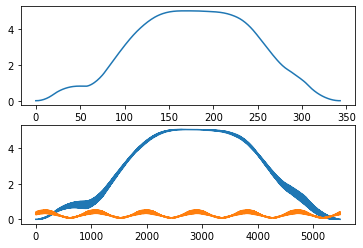

Max deviation:  0.5209376


In [31]:
fig, axs = plt.subplots(2, 1)
# Centerline deviation
centerline_deviations = [la.norm(point) for point in np.array(new_rod.deformedPoints()) - np.array(new_rod.restPoints())]
axs[0].plot(centerline_deviations)
# Geometry deviation
geometry_deviations = [la.norm(point) for point in equilibrium_geometry[0] - input_geometry[0]]
axs[1].plot(geometry_deviations)
# Geometry deviation after registration transformation
registration_deviations = [la.norm(point) for point in equilibrium_geometry[0] - transformed_input]
axs[1].plot(registration_deviations)
plt.show()
print('Max deviation: ', np.max(registration_deviations))

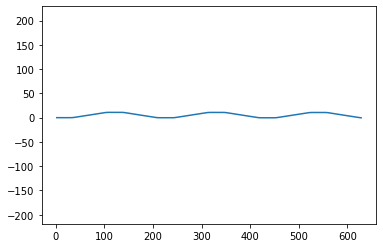

number of data point:  342
cost:  8.095512719998515
fitted function:  5.7311 * sin(0.03 * x + (-2.0666)) + 5.2327


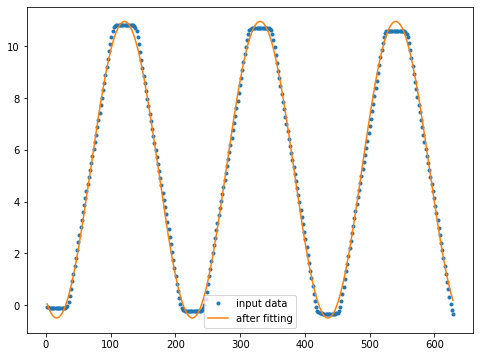

In [32]:
from scipy.optimize import least_squares
import numpy as np

strips = order_segments_by_strips(linkage)
all_strip_angle, all_strip_edge_len, all_strip_num_seg, all_extra_first_edge = get_turning_angle_and_length_from_ordered_rods(strips, linkage, rest = True)
xs, ys = get_curve_from_angle(all_strip_angle[0], all_strip_edge_len[0])

input_x = xs
input_y = ys

sine_func = lambda x: x[0] * np.sin( x[1] * input_x + x[2] ) + x[3] - input_y
result = least_squares(sine_func, [15, np.pi / 120, -3*np.pi / 12, np.mean(input_y)])
sol = result.x

plot_x = np.arange(min(input_x),max(input_x),0.1)
plot_fitted_y = sol[0]*np.sin(sol[1]*plot_x+sol[2]) + sol[3]


print('number of data point: ', len(input_x))
print('cost: ', result.cost)
print('fitted function: ', '{} * sin({} * x + ({})) + {}'.format(round(sol[0], 4), round(sol[1], 4), round(sol[2], 4), round(sol[3], 4)))
f = plt.figure(1, figsize=(8,6))
ax = f.add_subplot(1,1,1)
plt.plot(input_x, input_y, '.', label='input data')
plt.plot(plot_x, plot_fitted_y, label='after fitting')
# ax.set_aspect('equal')
plt.legend()
plt.show()

### Get laser cutting pattern

In [11]:
get_all_curve_pattern(linkage, RIBBON_CS[1], SUBDIVISION_RESOLUTION, RIBBON_NAME, image_type='png')

../compute_curve_from_curvature.py:248: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')
